In [1]:
## all the imports all of them just incase 
import torch
import torchvision
from torchvision import datasets
from torchvision import io
from torchvision import models
from torchvision import ops
from torchvision import transforms
from torchvision import utils



from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [2]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
## I am loading in the data
image_size = 128
BATCH_SIZE = 32 
DATA_DIR= '/Users/malikagolshan/Desktop/z1'

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()])

train_data = torchvision.datasets.ImageFolder(root= DATA_DIR, transform=TRANSFORM_IMG)
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=TRANSFORM_IMG)
test_data_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

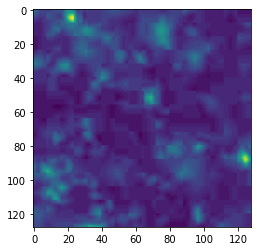

In [4]:
#Plotting the image 
images, labels = next(iter(train_data_loader))
plt.imshow(np.squeeze(next(iter(images))[0]/255))

In [5]:
## Adrains 

class model_p(nn.Module):
    def __init__(self,  hidden=4, dr= 0.1):
        super(model_p, self).__init__()
        
        kernel_size = 3  # 4
        padding = 1
        
        # input: 1x512x512 ---------------> output: hiddenx256x256 (the stride of 2 with pad of 1 halves dim)
        self.C1 = nn.Conv2d(3,         hidden, kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.B1 = nn.BatchNorm2d(hidden)
        
        # input: hiddenx256x256 ----------> output: 2*hiddenx128x128
        self.C2 = nn.Conv2d(hidden,   2*hidden, kernel_size=kernel_size, stride=2, padding=padding, bias=True)
        self.B2 = nn.BatchNorm2d(2*hidden)
        
        # input: 2*hiddenx128x128 --------> output: 4*hiddenx64x64
        self.C3 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=kernel_size, stride=2, padding=padding, bias=True)
        self.B3 = nn.BatchNorm2d(4*hidden)
        
        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C4 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=kernel_size, stride=2, padding=padding, bias=True)
        self.B4 = nn.BatchNorm2d(8*hidden)
        
        # input: 8*hiddenx32x32 --------> output: 16*hiddenx16x16
        self.C5 = nn.Conv2d(8*hidden, 16*hidden, kernel_size=kernel_size, stride=2, padding=padding, bias=True)
        self.B5 = nn.BatchNorm2d(16*hidden)
        
        # input: 16*hiddenx16x16 --------> output: 32*hiddenx8x8
        self.C6 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=kernel_size, stride=2, padding=padding, bias=True)
        self.B6 = nn.BatchNorm2d(32*hidden)
        
        # input: 32*hiddenx8x8 ----------> output: 64*hiddenx4x4
        self.C7 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.B7 = nn.BatchNorm2d(64*hidden)
        
        # input: 64*hiddenx4x4 ----------> output: 50x4x4
        self.C8 = nn.Conv2d(64*hidden, 50, kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.B8 = nn.BatchNorm2d(50)

        self.FC1  = nn.Linear(50*4*4, 400)  
        self.FC2  = nn.Linear(400,   100)    
        self.FC3  = nn.Linear(100,   1)    


        self.Dropout   = nn.Dropout(p=dr)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        #self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):# or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):
        x = self.LeakyReLU(self.C1(image))
        x = self.LeakyReLU(self.B2(self.C2(x)))
        x = self.LeakyReLU(self.B3(self.C3(x)))
        x = self.LeakyReLU(self.B4(self.C4(x)))
        x = self.LeakyReLU(self.B5(self.C5(x)))
        x = self.LeakyReLU(self.B6(self.C6(x)))
        x = self.LeakyReLU(self.B7(self.C7(x)))
        x = self.LeakyReLU(self.B8(self.C8(x)))
        x = x.view(image.shape[0],-1)#x = x.view(x.size(0), -1)#x = x.view(image.shape[0],-1)
        #print(x.data.shape)
        x = self.LeakyReLU(self.FC1(x))
        x = self.LeakyReLU(self.FC2(x))
        x = self.Dropout(x)
        x = self.FC3(x)
        # INCLUDE SIGMOID OUTSIDE OF NEWTORK (torch.nn.BCEWithLogitsLoss is more stable)

        return x



In [6]:
model = model_p()

In [7]:
def binary_acc(y_pred, y_test):
            y_pred_tag = torch.round(torch.sigmoid(y_pred))

            correct_results_sum = (y_pred_tag == y_test).sum().float()
            acc = correct_results_sum/y_test.shape[0]
            acc = torch.round(acc * 100)

In [8]:
loss_function = nn.BCELoss()  

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)  


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [10]:
 criterion = nn.BCEWithLogitsLoss()

In [11]:
#  for x,y in test_data_loader:
#                 with torch.no_grad():
#                     x, y = x.to(device), y.to(device)
#                     y = y.unsqueeze(1)
#                     y_NN = model(x)
#                     loss = criterion(y_NN,y)
#                     acc = binary_acc(y_NN, y)
# #                     test_loss += (loss.cpu().item())*x.shape[0]
# #                     test_acc += (acc.cpu().item())*x.shape[0]
# #                     num_points += x.shape[0]
# # test_loss = test_loss/num_points
# # test_acc = test_acc/num_points


In [12]:
# import torch
# from torch.autograd import Variable

# model = model
# LEARNING_RATE = 0.003
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# loss_func = nn.BCELoss()
# EPOCHS = 2


#     # Training and Testing
# for epoch in range(EPOCHS):        
#     for step, (x, y) in enumerate(train_data_loader):
#         b_x = Variable(x)   # batch x (image)
#         b_y = Variable(y)   # batch y (target)
#         output = model(b_x)[0]          
#         loss = loss_func(output, b_y)   
#         optimizer.zero_grad()           
#         loss.backward()                 
#         optimizer.step()


#         if step % 50 == 0:
#             test_x = Variable(test_data_loader)
#             test_output, last_layer = model(test_x)
#             pred_y = torch.max(test_output, 1)[1].data.squeeze()
#             accuracy = sum(pred_y == test_y) / float(test_y.size(0))
#             print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0],'| test accuracy: %.2f' % accuracy)


In [13]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)  
loss_func = nn.BCEWithLogitsLoss()

epochs = 2
loss_list = []
acc_list = []
model.train()

for epoch in range(epochs):
    total_loss = []
    total_acc  = []
    
    for X_tr, Y_tr in test_data_loader:
        #X_tr = X_tr.unsqueeze(1)
      
     
        #Y_tr = Y_tr.type(torch.LongTensor)
        Y_tr = Y_tr.unsqueeze(1)
      
        optimizer.zero_grad()
        output = model(X_tr.float())
        
        acc = binary_acc(output, Y_tr.float())

        pred = output.argmax(dim=1, keepdim=True)

        loss = loss_func(output, Y_tr.float())
         
        loss.backward()z
       
        optimizer.step()
        
        total_loss.append(loss.item())

    loss_list.append(sum(total_loss)/len(total_loss))

    
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
         100. * (epoch + 1) / epochs, loss_list[-1]))
 

Training [50%]	Loss: 0.7331
Training [100%]	Loss: 0.6949
